### The purpose of this notebook is to display the original DPMM scores signals and their post-processed  (shift and Gaussian smoothing) versions.

In [1]:
import os
import json
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# from utils.scoring_utils import dpmm_calc_scores, score_dataset, avg_scores_by_trans
from utils.scoring_utils import score_align

from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import roc_auc_score

### My override score_align

In [2]:
def my_score_align(scores_np, gt, seg_len=12, sigma=40):
    scores_shifted = np.zeros_like(scores_np)
    shift = seg_len + (seg_len // 2) - 1
    scores_shifted[shift:] = scores_np[:-shift]
    scores_smoothed = gaussian_filter1d(scores_shifted, sigma)
    # auc = roc_auc_score(gt, scores_smoothed)
    try:
        auc = roc_auc_score(gt, scores_smoothed)
    except ValueError: # Only one class present in y_true. ROC AUC score is not defined in that case.
        auc = 0
    return auc, shift, sigma, scores_smoothed

### Set Paths

In [3]:
home_dir = '/home/xpct84'
gepc_root_dir = os.path.join(home_dir, 'gepc')
data_dir = os.path.join(gepc_root_dir, 'data')
pose_dir = os.path.join(data_dir, 'pose') 
pose_testing_dir = os.path.join(pose_dir, 'testing')
print(pose_testing_dir)
testing_dir = os.path.join(data_dir, 'testing')
print(testing_dir)

/home/xpct84/gepc/data/pose/testing
/home/xpct84/gepc/data/testing


### Load Ground Truth, Scores, Scores Ids, Metadata 
  
Length of Ground Truth, Scores, and Scores Ids is video length in frames.  
Ground truth is 0 for normal and 1 for abnormal per frame.  
Scores are DPMM (Dirichlet Process Mixture Model) scores per frame.  
Score ids is the person id with max DPMM score (verify).  

Metadata is a (scene_id, clip_id) pai.

In [51]:
data = np.load('mat.npz')
gt_np = data['gt_np']
scores_np = data['scores_np']
score_ids_np = data['score_ids_np']
print(len(gt_np), len(scores_np), len(score_ids_np))
print(gt_np)
print(scores_np)
print(score_ids_np)

698 698 698
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

In [42]:
# dump(metadata_arr, 'metadata.pkl')
# metadata_arr = pickle.load('metadata.pkl', 'r')
# metadata_arr

with open('metadata.pkl', 'rb') as f:
    metadata_arr = pickle.load(f)
print(metadata_arr)

[[1, 14], [1, 15]]


### Original AUC

In [43]:
auc, shift, sigma = score_align(scores_np, gt_np)
# auc, shift, sigma = score_align(scores_np[:265], gt_np[:265])
# auc, shift, sigma = score_align(scores_np[265:], gt_np[265:])
print(auc, shift, sigma)

0.8739060340856748 17 40


### AUC without smoothing

In [26]:
auc = roc_auc_score(gt_np, scores_np)
print(auc)

0.5953077137287663


### AUC after chopping first 50 frames from signal (score an gt)

In [8]:
def runs_of_ones_array(bits):
  # make sure all runs of ones are well-bounded
  bounded = np.hstack(([0], bits, [0]))
  # get 1 at run starts and -1 at run ends
  difs = np.diff(bounded)
  run_starts, = np.where(difs > 0)
  run_ends, = np.where(difs < 0)
  return run_ends - run_starts, run_starts, run_ends

In [44]:
# gt_np
# scores_np
# # score_ids_np # not relevant
# metadata_arr

filename_num_frames = []
num_frames = np.zeros(len(metadata_arr))
i = 0
for scene_id, video_id in metadata_arr:
    # print(scene_id, video_id)
    # print(f'{scene_id:02}_{video_id:04}.npy')
    
    filename = f'{scene_id:02}_{video_id:04}.npy'
    full_fname = os.path.join(testing_dir, 'test_frame_mask_orig', filename)
    gt = np.load(full_fname)
    _, runs_starts, run_ends = runs_of_ones_array(gt)
    # print(filename, ', #frames =', len(gt), ', any(abnormal) =', any(gt==1), ',', runs_starts, run_ends-1)    
        
    num_frames[i] = len(gt)
    filename_num_frames.append((filename, len(gt)))
    i += 1
    
# num_frames   
# filename_num_frames

sorted(filename_num_frames, key=lambda x:x[1])

[('01_0014.npy', 265), ('01_0015.npy', 433)]

### AUC as function of sigma

In [28]:
auc_sigma_list = np.zeros(51)
for sigma in range(1, 51):
    auc_sigma_list[sigma], shift, sigma = score_align(scores_np, gt_np, seg_len=12, sigma=sigma)
    print(auc_sigma_list[sigma], shift, sigma)

0.6905458089668616 17 1
0.7197159565580618 17 2
0.753411306042885 17 3
0.78536619326093 17 4
0.8131439710387078 17 5
0.8437064884433305 17 6
0.8636869952659427 17 7
0.8731551099972152 17 8
0.8874965190754665 17 9
0.8964076858813702 17 10
0.9000278473962684 17 11
0.9030910609857978 17 12
0.9122807017543859 17 13
0.9218184349763298 17 14
0.9317738791423003 17 15
0.9428432191590087 17 16
0.9548872180451129 17 17
0.9637287663603453 17 18
0.9662350320245058 17 19
0.9681843497632971 17 20
0.969785575048733 17 21
0.9711779448621554 17 22
0.9720829852408799 17 23
0.9731272626009467 17 24
0.9738930659983291 17 25
0.9748677248677249 17 26
0.9756335282651072 17 27
0.9763993316624896 17 28
0.977165135059872 17 29
0.9779309384572542 17 30
0.9787663603453077 17 31
0.97953216374269 17 32
0.9805068226120857 17 33
0.9814118629908104 17 34
0.9825953773322195 17 35
0.9837092731829574 17 36
0.9849624060150375 17 37
0.9863547758284601 17 38
0.9877471456418825 17 39
0.9893483709273183 17 40
0.99087997772208

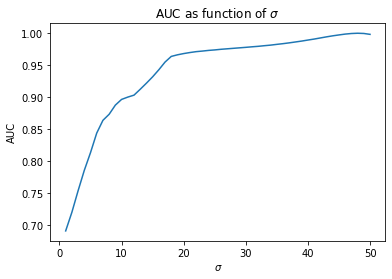

In [29]:
plt.plot(range(1,51), auc_sigma_list[1:])
plt.xlabel('$\sigma$')
plt.ylabel('AUC')
plt.title('AUC as function of $\sigma$')
# plt.savefig('AUCvsSigma.png')
plt.show()

In [30]:
np.argmax(auc_sigma_list)

48

In [31]:
full_filenames = sorted(glob.glob(os.path.join(testing_dir, 'test_frame_mask_orig', '*.npy')))
print(full_filenames)

['/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0014.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0015.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0016.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0025.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0026.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0027.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0028.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0029.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0030.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0051.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0052.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0053.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0054.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0055.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0056.

### All ShanghaiTech videos contain Anomaly

### Find length of sequences of identical values in a numpy array (run length encoding)  

https://stackoverflow.com/questions/1066758/find-length-of-sequences-of-identical-values-in-a-numpy-array-run-length-encodi

In [14]:
def runs_of_ones_array(bits):
  # make sure all runs of ones are well-bounded
  bounded = np.hstack(([0], bits, [0]))
  # get 1 at run starts and -1 at run ends
  difs = np.diff(bounded)
  run_starts, = np.where(difs > 0)
  run_ends, = np.where(difs < 0)
  return run_ends - run_starts, run_starts, run_ends

### Loop over metadata filenames, and plot all 107 scores and post-processed scores

In [32]:
for full_fname in full_filenames:
    a = np.load(full_fname)
    _, runs_starts, run_ends = runs_of_ones_array(a)
    print(os.path.basename(full_fname), ', #frames =', len(a), ', any(abnormal) =', any(a==1), ',', runs_starts, run_ends-1)

01_0014.npy , #frames = 265 , any(abnormal) = True , [154] [229]
01_0015.npy , #frames = 433 , any(abnormal) = True , [86] [373]
01_0016.npy , #frames = 337 , any(abnormal) = True , [188] [278]
01_0025.npy , #frames = 601 , any(abnormal) = True , [148] [202]
01_0026.npy , #frames = 505 , any(abnormal) = True , [278] [397]
01_0027.npy , #frames = 409 , any(abnormal) = True , [ 77 150] [148 151]
01_0028.npy , #frames = 457 , any(abnormal) = True , [266 330] [328 330]
01_0029.npy , #frames = 313 , any(abnormal) = True , [133] [245]
01_0030.npy , #frames = 409 , any(abnormal) = True , [149] [348]
01_0051.npy , #frames = 337 , any(abnormal) = True , [ 98 260] [201 325]
01_0052.npy , #frames = 337 , any(abnormal) = True , [119 153] [128 231]
01_0053.npy , #frames = 457 , any(abnormal) = True , [80 86] [ 84 315]
01_0054.npy , #frames = 577 , any(abnormal) = True , [145] [437]
01_0055.npy , #frames = 313 , any(abnormal) = True , [68] [312]
01_0056.npy , #frames = 529 , any(abnormal) = True , [

### Same as above, but using metadata_arr which is more correct.

In [45]:
num_frames = np.zeros(len(metadata_arr), dtype=int)
i = 0
for scene_id, video_id in metadata_arr:
    # print(scene_id, video_id)
    # print(f'{scene_id:02}_{video_id:04}.npy')
    
    filename = f'{scene_id:02}_{video_id:04}.npy'
    full_fname = os.path.join(testing_dir, 'test_frame_mask_orig', filename)
    gt = np.load(full_fname)
    _, runs_starts, run_ends = runs_of_ones_array(gt)
    # print(os.path.basename(full_fname), ', #frames =', len(gt), ', any(abnormal) =', any(gt==1), ',', runs_starts, run_ends-1)    
    print(filename, ', #frames =', len(gt), ', any(abnormal) =', any(gt==1), ',', runs_starts, run_ends-1)    
        
    num_frames[i] = len(gt)
    i += 1

01_0014.npy , #frames = 265 , any(abnormal) = True , [154] [229]
01_0015.npy , #frames = 433 , any(abnormal) = True , [86] [373]


In [46]:
print(num_frames)

[265 433]


In [47]:
def start_end_frames(num_frames):
    end_frames = np.cumsum(num_frames)
    start_frames = end_frames[:-1]
    start_frames = np.insert(start_frames, 0, 0)    
    return start_frames, end_frames

start_frames, end_frames = start_end_frames(num_frames)
print(start_frames)
print(end_frames)

[  0 265]
[265 698]


In [48]:
for i in range(len(start_frames)):
    print(gt_np[start_frames[i]:end_frames[i]])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 

In [49]:
for i in range(len(start_frames)):
    print(scores_np[start_frames[i]:end_frames[i]])

[48.01218101 48.01264934 46.89920653 48.01272308 45.77678975 45.1118231
 48.01252643 48.01239414 48.00523161 47.43119686 45.22984437 45.2282598
 45.22865192 45.23025123 45.23013518 45.22909986 46.67277366 45.11121321
 45.11127537 45.1831842  45.13503185 45.11113381 45.11115024 45.11114735
 45.11121491 45.11119297 45.111076   45.15191065 45.1111225  45.22920719
 45.11114403 45.11107961 45.11112895 45.11125397 45.11115348 45.11120207
 48.01274598 48.01250586 48.01241816 48.01235437 48.00875203 41.36370323
 44.76991815 41.3637226  41.36374533 41.36373215 45.20730132 45.22769575
 45.22770394 45.22922634 48.0122188  48.01231187 48.01264631 40.18953274
 48.01229459 48.01221213 48.01220392 48.0122192  48.01219914 48.01227349
 48.01226991 48.01229529 48.01223538 48.01220834 48.01226171 48.01223995
 48.01223803 48.01230973 48.01225111 48.01229747 45.78546591 45.22876845
 45.45641249 45.21575273 47.45592243 48.01221934 48.01226153 46.89965802
 45.22877195 45.22993484 44.35651644 45.11265841 45.1

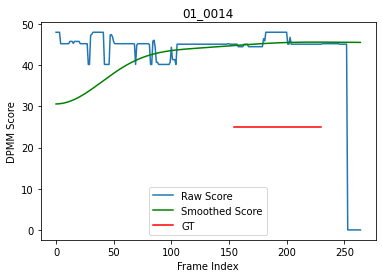

0.8664021164021165


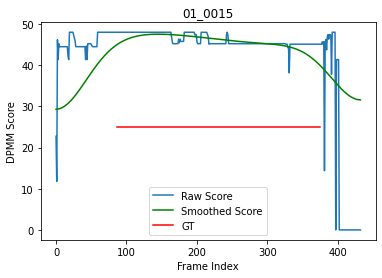

0.9855603448275861


In [52]:
auc_list = np.zeros(len(start_frames))
for i in range(len(start_frames)):
    
    scene_id, video_id = metadata_arr[i]
    filename = f'{scene_id:02}_{video_id:04}'
    
    # plot raw score
    clip_score = scores_np[start_frames[i]:end_frames[i]]    
    plt.plot(np.arange(len(clip_score)), clip_score, label='Raw Score')
    
    # set ground truth
    clip_gt = gt_np[start_frames[i]:end_frames[i]]
    
    # plot smoothed score
    # print(len(clip_score), len(clip_gt))
    auc, shift, sigma, scores_smoothed = my_score_align(clip_score, clip_gt)
    auc_list[i] = auc
    
    plt.plot(np.arange(len(scores_smoothed)), scores_smoothed, 'g', label='Smoothed Score')
    
    # plot ground truth    
    _, runs_starts, run_ends = runs_of_ones_array(clip_gt)
    for j in range(len(runs_starts)):
        if j == 0:
            plt.plot([runs_starts[j], run_ends[j]], [25, 25], 'r', label='GT')
        else:
            plt.plot([runs_starts[j], run_ends[j]], [25, 25], 'r')
        
    plt.legend(loc = 'lower center')
    
    plt.xlabel('Frame Index')
    plt.ylabel('DPMM Score')
    plt.title(filename)
    # plt.savefig(filename + '.png')
    plt.show()
    
    print(auc)

In [26]:
auc_list

array([0.96449457, 0.98045977, 0.80201912, 0.45624376, 0.67140693,
       0.56607503, 0.49125318, 0.97969027, 0.99301435, 0.71363156,
       0.90014498, 0.51192256, 0.84145316, 1.        , 0.79155856,
       0.88570769, 1.        , 0.8975469 , 0.77377487, 0.59404881,
       0.58015936, 0.7270189 , 0.65168539, 0.40740741, 0.71536617,
       0.86178451, 0.73953509, 0.97176166, 0.77272727, 0.99045988,
       0.65429415, 0.64044944, 0.69655172, 0.99634888, 0.57700348,
       0.58119658, 0.89439828, 0.86641791, 0.83713956, 0.31563461,
       0.65861906, 0.95499078, 0.58262243, 0.63970865, 0.97026783,
       0.94668565, 0.50230314, 0.58858004, 0.91516996, 0.95705913,
       0.75499114, 0.        , 0.87139618, 0.63573005, 0.75135179,
       0.89445699, 0.84877193, 0.4354874 , 0.9458589 , 0.97596965,
       0.99958597, 0.50471353, 0.67482307, 0.19127517, 0.59335219,
       0.4539627 , 0.74296853, 0.99106093, 0.75675676, 0.87949951,
       0.99734959, 0.93758177, 0.67789048, 0.57419752, 0.51082

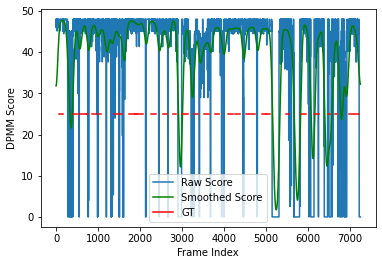

0.7908367600902692


In [31]:
# for i in range(len(start_frames)):
i = 21
num_videos = 20
    
# scene_id, video_id = metadata_arr[i]
# filename = f'{scene_id:02}_{video_id:04}'

# plot raw score
clip_score = scores_np[start_frames[i]:end_frames[i+num_videos]]    
plt.plot(np.arange(len(clip_score)), clip_score, label='Raw Score')

# set ground truth
clip_gt = gt_np[start_frames[i]:end_frames[i+num_videos]]

# plot smoothed score
# print(len(clip_score), len(clip_gt))
auc, shift, sigma, scores_smoothed = my_score_align(clip_score, clip_gt)
# auc_list[i] = auc

plt.plot(np.arange(len(scores_smoothed)), scores_smoothed, 'g', label='Smoothed Score')

# plot ground truth    
_, runs_starts, run_ends = runs_of_ones_array(clip_gt)
for j in range(len(runs_starts)):
    if j == 0:
        plt.plot([runs_starts[j], run_ends[j]], [25, 25], 'r', label='GT')
    else:
        plt.plot([runs_starts[j], run_ends[j]], [25, 25], 'r')

plt.legend(loc = 'lower center')

plt.xlabel('Frame Index')
plt.ylabel('DPMM Score')
# plt.title(filename)
# plt.savefig(filename + '.png')
plt.show()

print(auc)

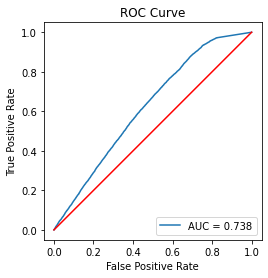

In [20]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(gt_np,  scores_np)

auc, shift, sigma = score_align(scores_np, gt_np)

#create ROC curve
# plt.plot(fpr,tpr,label="AUC="+str(auc))  f"The number is {num:.2f}"
plt.plot(fpr, tpr, label = f"AUC = {auc:.3f}")
plt.plot([0,1],[0, 1], 'r')
plt.axis('square')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC Curve')
# plt.savefig('ROC.png')
plt.show()